In [25]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns

In [45]:
sns.set(rc={'figure.figsize':(10,8)})

In [46]:
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [47]:
query = '''
 SELECT t1.id, title, CAST(avg_rating AS FLOAT64), 
        CAST(std as FLOAT64) std, CAST(play_time AS INT64) play_time
 
 FROM TOP_GAMES_FULL t1
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]

In [48]:
df = pd.DataFrame(data=result_li, columns = ['id','title','score', 'std','play_time'])

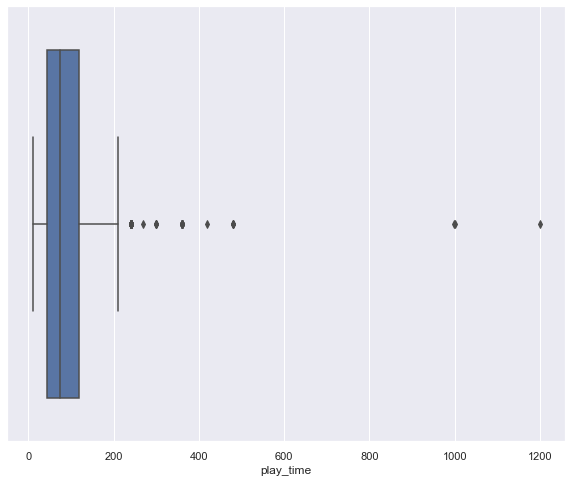

In [49]:
sns.boxplot(df['play_time'])

In [50]:
df.sort_values('play_time', ascending=False).head(15)

,id,title,score,std,play_time
317,255984,sleeping_gods,8.61552,1.39918,1200
38,180263,7th_continent,8.09348,1.63416,1000
997,234669,legacy_dragonholt,7.27396,1.71204,999
5,233078,twilight_imperium_fourth_edition,8.68469,1.59933,480
333,243,advanced_squad_leader,7.99375,2.06461,480
168,91,paths_glory,8.05662,1.64940,480
604,29603,d_day_omaha_beach,8.27387,1.39239,480
709,41066,virgin_queen,8.04787,1.64665,420
536,130960,triumph_tragedy_european_balance_power_1936_1945,8.16149,1.44092,360
204,421,1830_railways_robber_barons,7.87979,1.61974,360


According to the boxplot, everything about ~200 is an outlier. However, I'll only remove the ones greater than 480 (8 hours) since I think the 3-4 hours games might be interesting)

In [51]:
df = df[df['play_time'] <= 480]

30 min to 2 hours is the most common, as expected

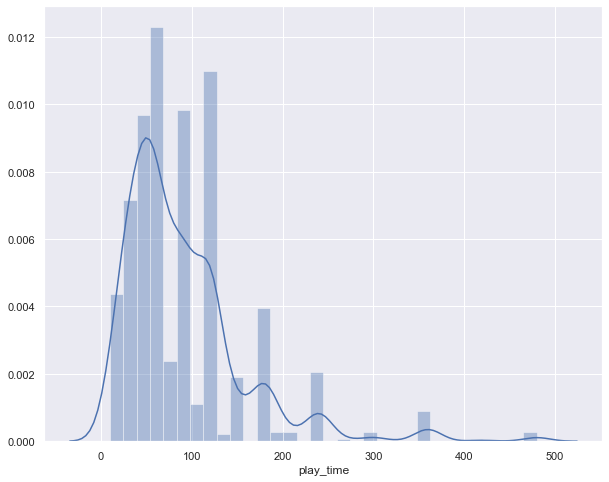

In [52]:
sns.distplot(df.play_time)

Is there a relationship between playtime and game score?

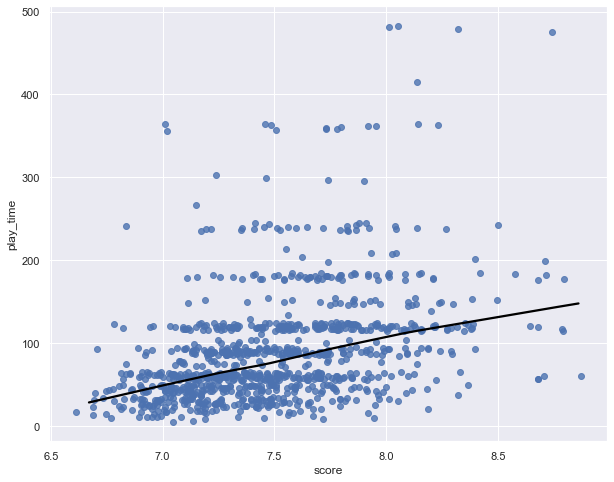

In [93]:
sns.regplot(data=df, x='score', y='play_time', lowess=True,line_kws={"color": "black"}, x_jitter=0.1, y_jitter=5)

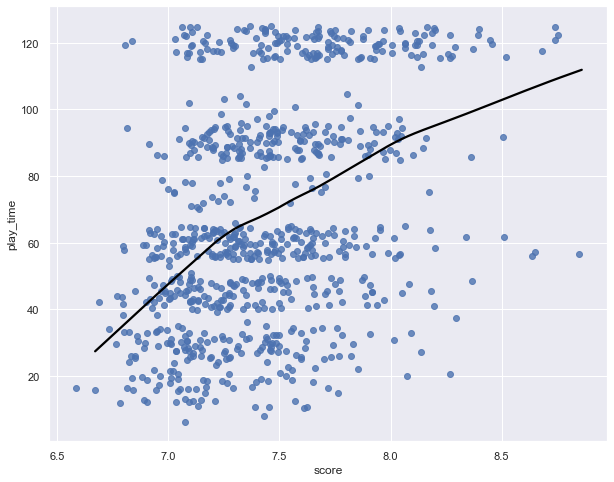

In [66]:
sns.regplot(data=df[df['play_time'] <= 120],
            x='score', y='play_time', lowess=True,line_kws={"color": "black"}, x_jitter=0.1, y_jitter=5)

Seems like longer games score better. Are longer games also more divisive?

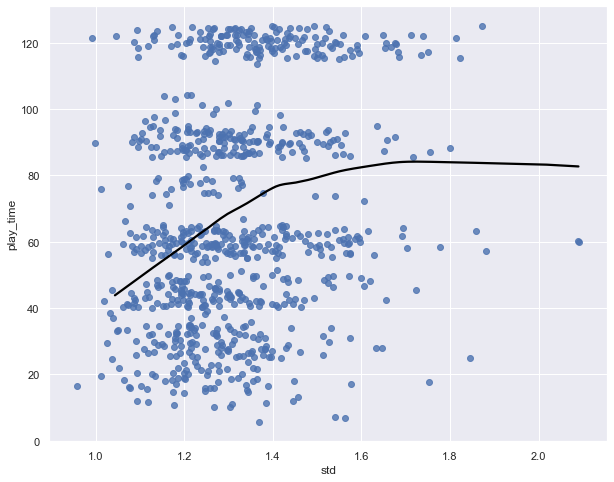

In [67]:
sns.regplot(data=df[df['play_time'] <= 120],
            x='std', y='play_time', lowess=True,line_kws={"color": "black"}, x_jitter=0.1, y_jitter=5)

Seems like they are more divisive as well.

Next step: Let's see if this relationship is statistically significant with a series of regression models

In [70]:
import statsmodels.formula.api as smf

In [75]:
results=smf.ols(data=df, formula ='score ~ play_time').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     184.8
Date:                Fri, 03 Sep 2021   Prob (F-statistic):           1.00e-38
Time:                        17:01:43   Log-Likelihood:                -394.43
No. Observations:                 997   AIC:                             792.9
Df Residuals:                     995   BIC:                             802.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2879      0.019    382.785      0.000       7.251       7.325
play_time      0.0023      0.000     13.593      0.000       0.002       0.003
==============================================================================
Omnibus:                       59.312   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.125
Skew:                           0.588   Prob(JB):                     5.92e-16
Kurtosis:                       3.550   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
results=smf.ols(data=df, formula ='score ~ play_time + play_time^2').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     92.56
Date:                Fri, 03 Sep 2021   Prob (F-statistic):           1.37e-37
Time:                        17:10:51   Log-Likelihood:                -394.20
No. Observations:                 997   AIC:                             794.4
Df Residuals:                     994   BIC:                             809.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.2873      0.019    382.297      0.000       7.250       7.325
play_time        -0.0018      0.006     -0.298      0.766      -0.014       0.010
play_time ^ 2     0.0041      0.006      0.669      0.504      -0.008       0.016
==============================================================================
Omnibus:                       57.878   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.010
Skew:                           0.582   Prob(JB):                     1.71e-15
Kurtosis:                       3.531   Cond. No.                         268.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
results=smf.ols(data=df, formula ='np.log(score) ~ np.log(play_time)').fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(score)   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     239.6
Date:                Fri, 03 Sep 2021   Prob (F-statistic):           1.40e-48
Time:                        17:07:06   Log-Likelihood:                 1648.6
No. Observations:                 997   AIC:                            -3293.
Df Residuals:                     995   BIC:                            -3283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.8745      0.009    206.776      0.000       1.857       1.892
np.log(play_time)     0.0324      0.002     15.478      0.000       0.028       0.037
==============================================================================
Omnibus:                       35.517   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.387
Skew:                           0.470   Prob(JB):                     4.62e-09
Kurtosis:                       3.203   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Testing: Adding Category

In [129]:
results = cur.execute('SELECT * FROM BGG_CATEGORIES')
result_li = [r for r  in results.fetchall()]
cat_df = pd.DataFrame(data=result_li, columns = ['id', 'category'])

In [130]:
cat_df.id.nunique()

388

Most popular categories

In [119]:
pivot = pd.pivot_table(data=cat_df,index='category',values='id',aggfunc='count').sort_values('id',ascending=False)
pivot.reset_index(inplace=True)
pivot.head(10)

,category,id
0,Economic,99
1,Card Game,95
2,Fantasy,83
3,Fighting,64
4,Science Fiction,56
5,Adventure,42
6,Miniatures,41
7,City Building,41
8,Medieval,37
9,Wargame,36


In [120]:
pivot = pivot[pivot.index <=9]

Let's make a dataframe that tells us whether or not a game has a certain category

In [121]:
new_df=pd.DataFrame(data=cat_df.id.unique(), columns=['id'])

In [122]:
for col in pivot.category:
    new_df[col] = 0

new_df.head()

,id,Economic,Card Game,Fantasy,Fighting,Science Fiction,Adventure,Miniatures,City Building,Medieval,Wargame
0,174430,0,0,0,0,0,0,0,0,0,0
1,161936,0,0,0,0,0,0,0,0,0,0
2,224517,0,0,0,0,0,0,0,0,0,0
3,167791,0,0,0,0,0,0,0,0,0,0
4,291457,0,0,0,0,0,0,0,0,0,0


In [123]:
for 

,id,Economic,Card Game,Fantasy,Fighting,Science Fiction,Adventure,Miniatures,City Building,Medieval,Wargame
0,174430,0,0,0,0,0,0,0,0,0,0
1,161936,0,0,0,0,0,0,0,0,0,0
2,224517,0,0,0,0,0,0,0,0,0,0
3,167791,0,0,0,0,0,0,0,0,0,0
4,291457,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
383,256999,0,0,0,0,0,0,0,0,0,0
384,140933,0,0,0,0,0,0,0,0,0,0
385,8989,0,0,0,0,0,0,0,0,0,0
386,121297,0,0,0,0,0,0,0,0,0,0
